# Transfer Learning 遷移學習
- 以下將利用 **[VGG16](https://keras.io/applications/#vgg16) 的模型與權重(參數)** 來訓練我的貓狗分類器

In [0]:
%tensorflow_version 2.x

In [0]:
# 下載資料時，mac 需要加這二行
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# 先看一下 VGG16 模型的樣子
from tensorflow.keras.applications.vgg16 import VGG16

VGG16(include_top=False,         # 只引用 CNN 的部分，不引用 MLP
      input_shape=(224, 224, 3)  # 盡量將影像尺寸設定的和原始模型一樣
      ).summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## step0: 載入資料並觀察

In [4]:
# 下載資料並解壓縮檔案
import os
import gdown   # Download a large file from Google Drive
import zipfile

filename = "dogcat.zip"
url = "https://drive.google.com/uc?id=104BpDQ4dBy4kK1PgEYukBFzcD_9OU2S3&export=download"

if not os.path.exists(filename):
    print("資料集不存在，下載中...")    
    gdown.download(url, filename, quiet=False)
    zfile = zipfile.ZipFile(filename)
    zfile.extractall("dataset")
else:
    print("資料集已經下載過了:)")

資料集已經下載過了:)


In [5]:
# 先將圖片路徑存成 DataFrame
# 要開始訓練模型時，再讀取圖片 (避免資料量太大，RAM 會爆掉！QAQ)
import glob
import pandas as pd

cat_fs = glob.glob("dataset/train/cat.*.jpg")
cat_ans = [0] * len(cat_fs)

dog_fs = glob.glob("dataset/train/dog.*.jpg")
dog_ans = [1] * len(cat_fs)

df = pd.DataFrame({
    "path": cat_fs + dog_fs,
    "target": cat_ans + dog_ans
})

df

,path,target
0,dataset/train/cat.5259.jpg,0
1,dataset/train/cat.2114.jpg,0
2,dataset/train/cat.9115.jpg,0
3,dataset/train/cat.7547.jpg,0
4,dataset/train/cat.9446.jpg,0
...,...,...
24995,dataset/train/dog.3611.jpg,1
24996,dataset/train/dog.9709.jpg,1
24997,dataset/train/dog.1655.jpg,1
24998,dataset/train/dog.7558.jpg,1


path: dataset/train/cat.5259.jpg
size: (320, 239)
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x239 at 0x7FCC000C5F60>


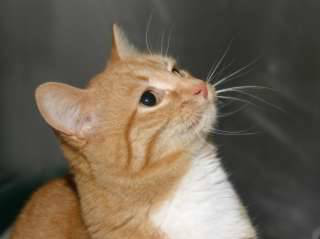

In [6]:
# 利用 keras 來讀取圖片
# 好處：keras 會直接將圖片轉成多維陣列
from tensorflow.keras.preprocessing.image import load_img

img_path = df["path"][0]
print('path:', img_path)

img = load_img(img_path)
print('size:', img.size)
print(img)
img

size: (224, 224)


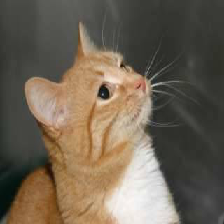

In [7]:
img = load_img(img_path, target_size=(224, 224)) # 改變圖片尺寸
print('size:', img.size)
img

## step1: 資料預處理
- **將資料傳進模型前，必須先轉成 numpy array！！！**  
  tensorflow 不喜歡 pd.DataFrame，也不喜歡 pd.Series

- 利用「**批次資料處理函式**」：要訓練時，再讀取並處理資料  
  避免一次載入資料量太大，記憶體會爆掉 T^T  
  - 不對 **題目** 做預處理  
    等到要訓練模型時，再針對隨機挑選（np.random.randint）的題目做預處理  
    而且在遷移學習時，引用誰的模型，就必須使用他的預處理方式

  - 不對 **答案** 做 one-hot encoding  
    等到要訓練模型時，再請模型用 sparse 自己做 one-hot encoding

In [0]:
# 將圖片路徑從 pd.DataFrame 轉為 np.array
# 目的：剔除 DataFrame 的列編號(索引)
from sklearn.model_selection import train_test_split
import numpy as np

x, y = np.array(df["path"]), np.array(df["target"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [9]:
print(x_train.shape, type(x_train))
print(y_train.shape, type(y_train))
print(x_test.shape, type(x_test))
print(y_test.shape, type(x_test))

(22500,) <class 'numpy.ndarray'>
(22500,) <class 'numpy.ndarray'>
(2500,) <class 'numpy.ndarray'>
(2500,) <class 'numpy.ndarray'>


In [0]:
# 批次資料處理函式
from tensorflow.keras.applications.vgg16 import preprocess_input

def batch_data_preprocess(x, y, BATCH=20):
    '''批次資料處理
       隨機選擇 X 筆資料，並只針對這 X 筆資料，做讀取與預處理
    '''
    idx = np.random.randint(0, x.shape[0], size=BATCH)
    img_original, img_process = [], []

    for path in x[idx]:        
        img = load_img(path, target_size=(224, 224))    # 利用keras 讀取圖片
        img = np.array(img)                             # 將圖片轉成多維陣列
        img_original.append(img)                        # 把原圖存起來
        img = preprocess_input(img)   # 引用誰的模型, 就必須使用他的預處理方式
        img_process.append(img)                         # 把處理過的圖存起來
    
    return (np.array(img_original), 
            np.array(img_process), 
            np.array(y[idx]))

- vgg16 preprocess_input mode is "caffe".
- [caffe](https://github.com/tensorflow/tensorflow/blob/r1.9/tensorflow/python/keras/applications/imagenet_utils.py) : will convert the images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset ( BGR [103.939, 116.779, 123.68] ), without scaling.

In [11]:
train = batch_data_preprocess(x_train, y_train)
print('img_original:', train[0].shape)
print('img_process :', train[1].shape)
print('ans/target  :', train[2].shape)

img_original: (20, 224, 224, 3)
img_process : (20, 224, 224, 3)
ans/target  : (20,)


- 備註：返回一個隨機整數
  1. 包含上限，包含下限：return `0 <= num <= 10` 
```python
import random
num = random.randint(0, 10)
```
  2. 包含上限，不包含下限：return `0 <= num < 10`
```python
import numpy as np
num = np.random.randint(0, 10)
```
 


## step2: 建立模型

### 引用模型：VGG16

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
# 對照著上面看，你就會知道誰是誰了XD
print("input :", vgg.input)
print("output:", vgg.output)
print("Layer :")
vgg.layers

input : Tensor("input_2:0", shape=(None, 224, 224, 3), dtype=float32)
output: Tensor("block5_pool_1/Identity:0", shape=(None, 7, 7, 512), dtype=float32)
Layer :


### 訓練模型：Sequential 
- Sequential 就像疊積木，必須一層接著一層，所以只適用在簡單的模型
- Model 可以平行輸入，可有多個 inputs 和 outputs，適合做複雜的模型
```python
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, Flatten

    model = Sequential()

    '''CNN (移植眼睛)'''
    for l in cnn.layers:
        l.trainable = False
        model.add(l)

    '''MLP (我的大腦)''' 
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(2, activation="softmax"))
    model.summary()
```

### 建立訓練模型：[Model](https://keras.io/models/model/) (Functional API)
- 貓狗分類可以選擇 `units = 1` 或 `units = 2`，但要注意 `activation` 不一樣
  - `x = Dense(units=1, activation="sigmoid")(x)`
  - `x = Dense(units=2, activation="softmax")(x)`

- 雙括號語法說明，例如：`Dense(2048)(input)` 
  - `Dense(2048)` 是創建類的實例（Class instantiation），  
    而第一個括號 `(2048)` 是提供給類實例的參數，並傳入`__init__()`；  
    意思就是創建一個 `Dense` 的 layer，並設定 `units=2048`  

  - `__call__()` 可以讓類的實例，像函數一樣被調用，  
    如 `x.__call__(arg1, arg2, ...)` = `x(arg1, arg2, ...)`；    
    故第二個括號 `(input)` 是透過 `call()` 調用一個無名的類實例，並傳入參數；  
    意思就是 `Dense(2048).__call__(input)` = `Dense(2048)(input)`  
    
  - source code：[tf.keras.Model](https://github.com/tensorflow/tensorflow/blob/v2.1.0/tensorflow/python/keras/engine/training.py#L81-L2865)、[tf.keras.layers.Dense](https://github.com/tensorflow/tensorflow/blob/v2.1.0/tensorflow/python/keras/layers/core.py#L1008-L1173) 

In [14]:
# 雙括號語法範例
def test():
    return int
test()(3.14)

3

------
#### **Batch Normalization（BN）** 
- 目的：解決 Internal Covariate Shift 現象：訓練資料集和測試資料集的數據分佈不一致

- 做法：平均數（$ mean $） 　 ： $ \mu    \Rightarrow 0 \Rightarrow \beta  $   
  　　　標準差（$ variance $）： $ \sigma \Rightarrow 1 \Rightarrow \gamma $
  1. 先做標準化（Normalize）：$ \hat{x_i} = \Large \frac{x_i-\mu_i}{\sqrt{\sigma_i^2+\epsilon}} $，使得 $ mean $ = 0  和 $ variance $ = 1 
  2. 再放缩平移（Scale and Shift）：$ y_i = \gamma \hat{x_i} + \beta $，
     優化 $ mean $ 和 $ variance $，  
     透過梯度下降的方法讓模型自己尋找最適合每個特徵的 $ mean $ 和 $ variance $

- 參考資料：
  1. [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shif](https://arxiv.org/pdf/1502.03167.pdf)
  2. [深度學習中 Batch Normalization 為什麼效果好？ | 魏秀參 | 知乎](https://www.zhihu.com/question/38102762)
  3. [遷移學習 ─ Domain Adaptation | Peanut_范 | CSDN](https://blog.csdn.net/u013841196/article/details/80956828)
  4. [covariate shift 現像以及解決方法 | guoyuhaoaaa | CSDN](https://blog.csdn.net/guoyuhaoaaa/java/article/details/80236500)

------
#### **Dying ReLU problem / Dead ReLU problem**
- 參考資料：
  1. [What is the "dying ReLU" problem in neural networks? | Data Science Stack Exchange](https://datascience.stackexchange.com/questions/5706/what-is-the-dying-relu-problem-in-neural-networks)
  2. [What is the 'dying ReLU' problem in neural networks? | Quora](https://www.quora.com/What-is-the-dying-ReLU-problem-in-neural-networks)
  3. [談談由異常輸入導致的 ReLU 神經元死亡的問題 | 始终](https://liam.page/2018/11/30/vanishing-gradient-of-ReLU-due-to-unusual-input/)

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout

'''CNN (眼睛)'''
# 不重新訓練權值，直接引用 VGG16 的權值
for l in vgg.layers:
    l.trainable = False  

'''BN (血管)'''
# 解決 Internal Covariate Shift
x = BatchNormalization()(vgg.output)

'''MLP (大腦)''' 
x = GlobalAveragePooling2D()(vgg.output)           # 以此取代 Flatten，以減少參數量
x = Dense(64, activation="relu")(x)
x = Dropout(0.25)(x)
output  = Dense(units=2, activation="softmax")(x)  # units=2 表示有 2 種分類

'''建立 model ''' 
model = Model(inputs=vgg.input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### 確定模型訓練方式
- `sparse`：請模型自己對答案做 one-hot encoding，以節省記憶體

In [0]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

### 訓練模型
- 批次資料訓練

In [17]:
for i in range(30):
    print("\n", "-" * 15, "Times", i+1, "-" * 15)
    # 訓練模型
    x_train_part_o, x_train_part, y_train_part = batch_data_preprocess(x_train, y_train)
    train_result = model.train_on_batch(x_train_part, y_train_part)
    print("Train:   ", train_result)

    # 驗證模型：測試資料
    x_test_part_o, x_test_part, y_test_part = batch_data_preprocess(x_test, y_test)
    test_result = model.test_on_batch(x_test_part, y_test_part)
    print("Validate:", test_result)


 --------------- Times 1 ---------------
Train:    [0.7836301326751709, 0.699999988079071]
Validate: [1.235879898071289, 0.699999988079071]

 --------------- Times 2 ---------------
Train:    [6.778128147125244, 0.5]
Validate: [0.5812798738479614, 0.800000011920929]

 --------------- Times 3 ---------------
Train:    [1.0985448360443115, 0.800000011920929]
Validate: [0.06605440378189087, 1.0]

 --------------- Times 4 ---------------
Train:    [2.0703117847442627, 0.699999988079071]
Validate: [0.01421807985752821, 1.0]

 --------------- Times 5 ---------------
Train:    [0.27754026651382446, 0.8999999761581421]
Validate: [0.2279093712568283, 0.949999988079071]

 --------------- Times 6 ---------------
Train:    [0.24052652716636658, 0.949999988079071]
Validate: [0.1738733947277069, 0.8999999761581421]

 --------------- Times 7 ---------------
Train:    [0.2104077786207199, 0.8999999761581421]
Validate: [0.1298227459192276, 0.949999988079071]

 --------------- Times 8 ---------------
T

## step3: 預測結果

In [18]:
# 如果都是 1，表示機率集中在很右邊；
# 如果都是 0，表示機率集中在很左邊
model.predict(x_test_part)

array([[1.0000000e+00, 5.4972157e-17],
       [1.0000000e+00, 1.5146895e-08],
       [3.6321726e-19, 1.0000000e+00],
       [1.0000000e+00, 1.6654682e-09],
       [2.2417335e-18, 1.0000000e+00],
       [1.0000000e+00, 3.1540204e-11],
       [7.7339423e-01, 2.2660574e-01],
       [4.2906883e-03, 9.9570930e-01],
       [2.2307070e-15, 1.0000000e+00],
       [1.0000000e+00, 4.3468402e-09],
       [5.4507990e-07, 9.9999940e-01],
       [8.6925072e-09, 1.0000000e+00],
       [4.5885934e-10, 1.0000000e+00],
       [1.2526459e-07, 9.9999988e-01],
       [7.5173620e-07, 9.9999928e-01],
       [2.2780495e-09, 1.0000000e+00],
       [2.3673826e-03, 9.9763262e-01],
       [1.0000000e+00, 1.5610554e-15],
       [1.1004903e-09, 1.0000000e+00],
       [2.4852325e-11, 1.0000000e+00]], dtype=float32)

## step4: 驗證模型

In [19]:
x_test_part_o, x_test_part, y_test_part = batch_data_preprocess(x_test, y_test, 1000)
model.evaluate(x_test_part, y_test_part)

32/32 [==============================] - 6s 195ms/step - loss: 0.2682 - accuracy: 0.9490


[0.2682447135448456, 0.9490000009536743]

### 印出預測錯誤的圖像

In [0]:
# 預測結果最大值的索引
# Model 沒有 predict_classes
pre = model.predict(x_test_part).argmax(axis=-1) # axis=1=-1 在行中找最大值
                                                 # axis=0    在列中找最大值

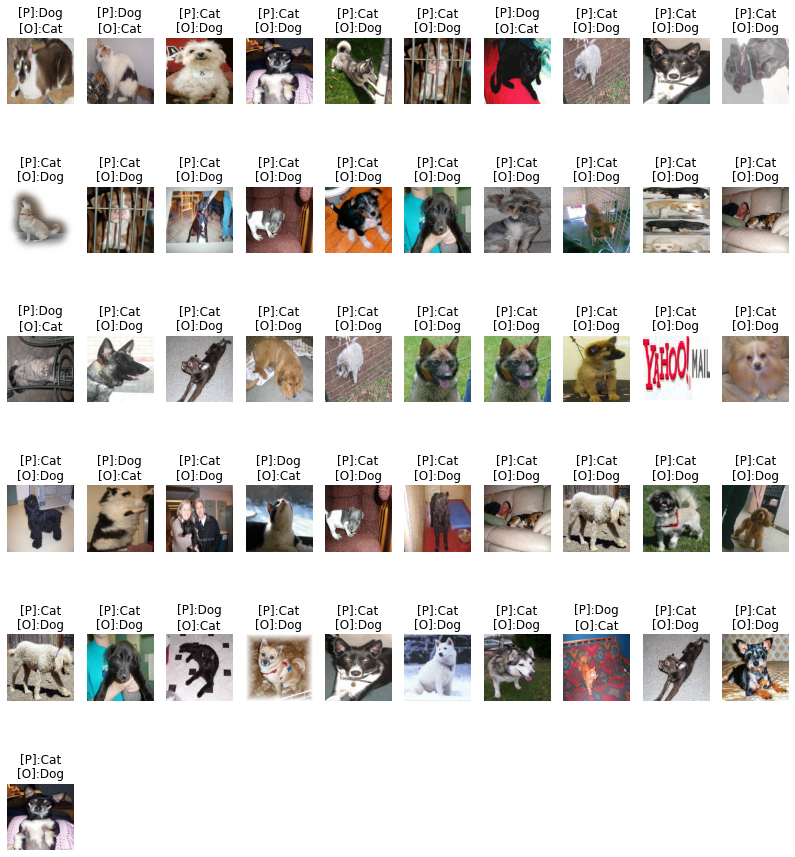

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

names = ["Cat", "Dog"]

idx = np.nonzero(pre != y_test_part)[0]
false_pre_img = x_test_part_o[idx]
false_pre_label = y_test_part[idx]
false_pre_predict = pre[idx]

plt.figure(figsize=(14, 16))
width = 10 
height = len(idx) // width + 1

for i, img in enumerate(false_pre_img):    
    plt.subplot(height, width, i+1)
    plt.title(f"[P]:{names[false_pre_predict[i]]}\n[O]:{names[false_pre_label[i]]}")
    plt.axis("off")
    plt.imshow(img)